Note: this analysis is for 13/56-57

TODO: requires 20 GB memory, make it more memory efficient?

## Get states for each work trajectory for A27K

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get dihedrals
def get_dihedrals(i, phase, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
#     modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_forward = []
    all_pos_reverse = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_new.npy"), "rb") as f:
                all_pos_forward.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_reverse_neq_new.npy"), "rb") as f:
                all_pos_reverse.append(np.load(f)[0])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_forward)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_forward), new_top)
    dihedrals_forward = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    traj = md.Trajectory(np.array(all_pos_reverse), new_top)
    dihedrals_reverse = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_forward, dihedrals_reverse

#### Get dihedrals for apo

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/88/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [5]:
dihedral_atoms = [['N', 'CA', 'CB', 'HB1'], ['N', 'CA', 'CB', 'CG']]
for res in htf._topology_proposal.old_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_new = res
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]

In [6]:
indices_old

[390, 391, 394, 399]

In [7]:
indices_new

[390, 391, 394, 399]

In [8]:
dihedrals_forward_apo, dihedrals_reverse_apo = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]

new files found: 100


#### Get dihedrals for complex

In [10]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/88/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [11]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [12]:
dihedral_atoms = [['N', 'CA', 'CB', 'HB1'], ['N', 'CA', 'CB', 'CG']]
for res in htf._topology_proposal.old_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_new = res
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]

In [13]:
indices_old

[390, 391, 394, 399]

In [14]:
dihedrals_forward_complex, dihedrals_reverse_complex = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


new files found: 100


In [15]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [16]:
# Create list of states for each work traj
states_forward_apo = [get_state(angle) for angle in dihedrals_forward_apo]
states_reverse_apo = [get_state(angle) for angle in dihedrals_reverse_apo]

states_forward_complex = [get_state(angle) for angle in dihedrals_forward_complex]
states_reverse_complex = [get_state(angle) for angle in dihedrals_reverse_complex]

In [17]:
with open(os.path.join(outdir, "state_forward_apo.npy"), "wb") as f:
    np.save(f, states_forward_apo)

with open(os.path.join(outdir, "state_reverse_apo.npy"), "wb") as f:
    np.save(f, states_reverse_apo)

with open(os.path.join(outdir, "state_forward_complex.npy"), "wb") as f:
    np.save(f, states_forward_complex)

with open(os.path.join(outdir, "state_reverse_complex.npy"), "wb") as f:
    np.save(f, states_reverse_complex)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

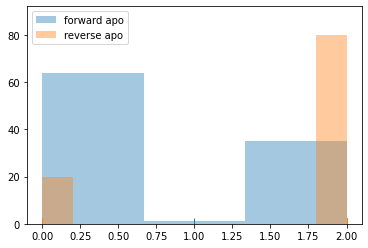

In [18]:
sns.distplot(states_forward_apo, label="forward apo", rug=True, kde=False)
sns.distplot(states_reverse_apo, label="reverse apo", rug=True, kde=False)
# sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
# sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

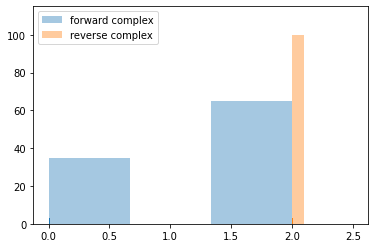

In [19]:
sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

## Run estimator on A27K

In [20]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [21]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [22]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
# titles = ["A42T"]
d_results = {}
d_phases = {}
first = 88
for i in tqdm_notebook([88]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


dir: 88
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 25

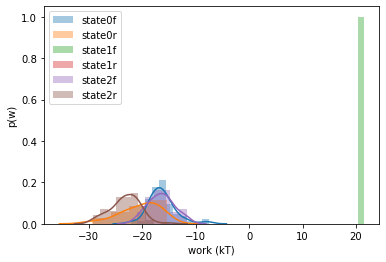

In [23]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo']['forward'], d_input_works['apo']['reverse'] = dict(), dict()
    d_input_works['complex']['forward'], d_input_works['complex']['reverse'] = dict(), dict()
    
    # Create lists for each state
    n_states = 3
    for i in range(n_states):
        d_input_works['apo']['forward'][i] = list()
        d_input_works['apo']['reverse'][i] = list()
        d_input_works['complex']['forward'][i] = list()
        d_input_works['complex']['reverse'][i] = list()
    
    n_cycles_apo = len(forward_apo_arrays)
    for i in range(n_cycles_apo):
        state_forward = states_forward_apo[i]
        state_reverse = states_reverse_apo[i]
        d_input_works['apo']['forward'][state_forward].append(forward_apo_accumulated[i])
        d_input_works['apo']['reverse'][state_reverse].append(reverse_apo_accumulated[i])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state_forward = states_forward_complex[i]
        state_reverse = states_reverse_complex[i]
        d_input_works['complex']['forward'][state_forward].append(forward_complex_accumulated[i])
        d_input_works['complex']['reverse'][state_reverse].append(reverse_complex_accumulated[i])

    # Plot work distributions
    for i in [0,1, 2]:
        sns.distplot(np.array(d_input_works['apo']['forward'][i]), label=f"state{i}f")
        sns.distplot(np.array(d_input_works['apo']['reverse'][i])*-1, label=f"state{i}r")
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.legend()
    plt.show()
#     plt.title(f"{title} {phase}")
#     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
#     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
#     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

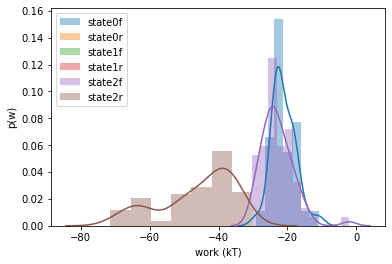

In [24]:
# Plot work distributions
plt.clf()
for i in [0, 1, 2]:
    sns.distplot(np.array(d_input_works['complex']['forward'][i]), label=f"state{i}f")
    sns.distplot(np.array(d_input_works['complex']['reverse'][i])*-1, label=f"state{i}r")
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.legend()
plt.show()

In [25]:
def combine(energies):
    final_sum = 0
    for energy in energies:
        final_sum += np.exp(-energy)
    return -np.log(final_sum)

def compute_ddg(d_works, states_apo, states_complex):
    
    # Initialize data structure for dgs
    d_dgs_state = {"complex": {}, "apo":{}}
    d_dgs_phase = {}

    # Compute and save dgs 
    for phase in phases:
        states = states_apo if phase == 'apo' else states_complex
        for state in states:
            dg, ddg = pymbar.bar.BAR(d_works[phase]['forward'][state], d_works[phase]['reverse'][state])
            d_dgs_state[phase][state] = (dg, ddg)
        d_dgs_phase[phase] = combine([d_dgs_state[phase][state][0] for state in states])

    return d_dgs_state, d_dgs_phase, d_dgs_phase['complex'] - d_dgs_phase['apo']

In [26]:
import tqdm
states_apo = [0, 2]
states_complex = [2]
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_state_all = []
dgs_phase_all = []
ddgs_all = []
for i in tqdm.trange(N_bootstraps):
    # Initialize data structure for works
    d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}
    
    # Save subsampled works
    for phase in phases:
        states = states_apo if phase == 'apo' else states_complex
        for direction in directions:
            for state in states:
                work_array = np.array(d_input_works[phase][direction][state])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction][state] = work_array[subsample_indices]
    d_dgs_state, d_dgs_phase, ddg = compute_ddg(d_works, states_apo, states_complex)
    dgs_state_all.append(d_dgs_state)
    dgs_phase_all.append(d_dgs_phase)
    ddgs_all.append(ddg)
    


100%|██████████| 10000/10000 [01:08<00:00, 145.98it/s]


In [27]:
dgs_state_all_A42T = dgs_state_all

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

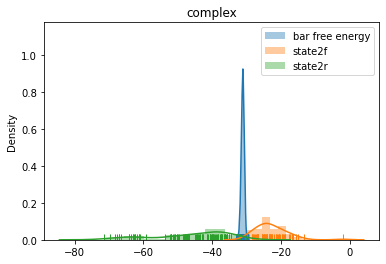

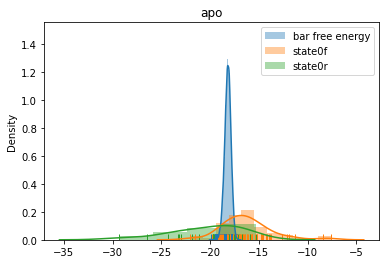

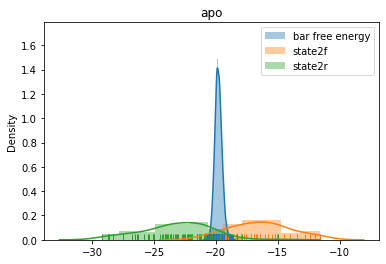

In [28]:
# Plot dgs for each state in apo
for phase in phases:
    states = states_apo if phase == 'apo' else states_complex
    for state in states:
        dgs = [d[phase][state][0] for d in dgs_state_all]
        sns.distplot(dgs, label=f"bar free energy", rug=True)
        sns.distplot(d_input_works[phase]['forward'][state], label=f"state{state}f", rug=True)
        sns.distplot(np.array(d_input_works[phase]['reverse'][state])*-1, label=f"state{state}r", rug=True)
        plt.title(phase)
        plt.legend()
        plt.show()

## Get states for each work trajectory for K27A

In [29]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller
import seaborn as sns


In [30]:
# Get dihedrals
def get_dihedrals(i, phase, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
#     modeller.deleteWater()
    old_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_forward = []
    all_pos_reverse = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_old.npy"), "rb") as f:
                all_pos_forward.append(np.load(f)[0])
        except FileNotFoundError:
            pass
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_reverse_neq_old.npy"), "rb") as f:
                all_pos_reverse.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_forward)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_forward), old_top)
    dihedrals_forward = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    traj = md.Trajectory(np.array(all_pos_reverse), old_top)
    dihedrals_reverse = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    
    return dihedrals_forward, dihedrals_reverse

#### Get dihedrals for apo

In [31]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/87/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [32]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [33]:
dihedral_atoms = [['N', 'CA', 'CB', 'CG'],  ['N', 'CA', 'CB', 'HB1']]
for res in htf._topology_proposal.old_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_new = res
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]

In [34]:
dihedrals_forward_apo, dihedrals_reverse_apo = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


new files found: 100


#### Get dihedrals for complex

In [35]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/87/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [36]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [37]:
dihedral_atoms = [['N', 'CA', 'CB', 'CG'],  ['N', 'CA', 'CB', 'HB1']]
for res in htf._topology_proposal.old_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == '27' and res.chain.index == 0:
        residue_new = res
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]

In [38]:
dihedrals_forward_complex, dihedrals_reverse_complex = get_dihedrals(i, phase, outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


new files found: 100


In [39]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [40]:
# Create list of states for each work traj
states_forward_apo = [get_state(angle) for angle in dihedrals_forward_apo]
states_reverse_apo = [get_state(angle) for angle in dihedrals_reverse_apo]

states_forward_complex = [get_state(angle) for angle in dihedrals_forward_complex]
states_reverse_complex = [get_state(angle) for angle in dihedrals_reverse_complex]

In [41]:
with open(os.path.join(outdir, "state_forward_apo.npy"), "wb") as f:
    np.save(f, states_forward_apo)

with open(os.path.join(outdir, "state_reverse_apo.npy"), "wb") as f:
    np.save(f, states_reverse_apo)

with open(os.path.join(outdir, "state_forward_complex.npy"), "wb") as f:
    np.save(f, states_forward_complex)

with open(os.path.join(outdir, "state_reverse_complex.npy"), "wb") as f:
    np.save(f, states_reverse_complex)

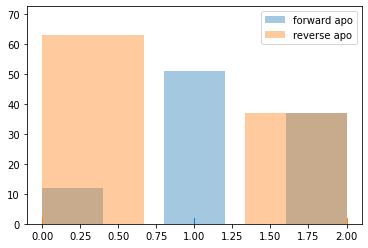

In [42]:
sns.distplot(states_forward_apo, label="forward apo", rug=True, kde=False)
sns.distplot(states_reverse_apo, label="reverse apo", rug=True, kde=False)
# sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
# sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

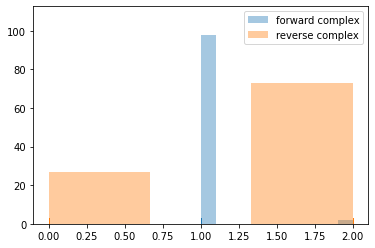

In [43]:
sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

## Run estimator on K27A

In [44]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [45]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [47]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
# titles = ["D39A"]
d_results = {}
d_phases = {}
first = 87
for i in tqdm_notebook([87]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


dir: 87
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 25

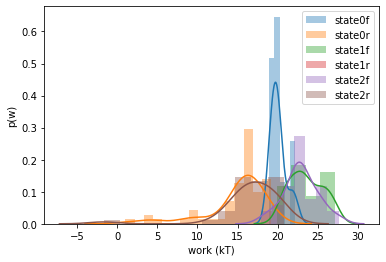

In [48]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo']['forward'], d_input_works['apo']['reverse'] = dict(), dict()
    d_input_works['complex']['forward'], d_input_works['complex']['reverse'] = dict(), dict()
    
    # Create lists for each state
    n_states = 3
    for i in range(n_states):
        d_input_works['apo']['forward'][i] = list()
        d_input_works['apo']['reverse'][i] = list()
        d_input_works['complex']['forward'][i] = list()
        d_input_works['complex']['reverse'][i] = list()
    
    n_cycles_apo = len(forward_apo_arrays)
    for i in range(n_cycles_apo):
        state_forward = states_forward_apo[i]
        state_reverse = states_reverse_apo[i]
        d_input_works['apo']['forward'][state_forward].append(forward_apo_accumulated[i])
        d_input_works['apo']['reverse'][state_reverse].append(reverse_apo_accumulated[i])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state_forward = states_forward_complex[i]
        state_reverse = states_reverse_complex[i]
        d_input_works['complex']['forward'][state_forward].append(forward_complex_accumulated[i])
        d_input_works['complex']['reverse'][state_reverse].append(reverse_complex_accumulated[i])

        
    # Plot work distributions
    for i in [0, 1, 2]:
        sns.distplot(np.array(d_input_works['apo']['forward'][i]), label=f"state{i}f")
        sns.distplot(np.array(d_input_works['apo']['reverse'][i])*-1, label=f"state{i}r")
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.legend()
    plt.show()
#     plt.title(f"{title} {phase}")
#     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
#     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
#     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

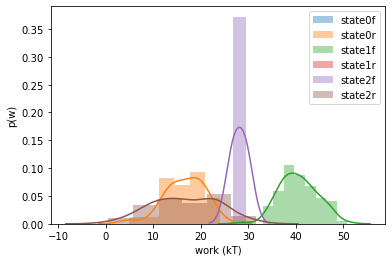

In [49]:
# Plot work distributions
plt.clf()
for i in [0, 1, 2]:
    sns.distplot(np.array(d_input_works['complex']['forward'][i]), label=f"state{i}f")
    sns.distplot(np.array(d_input_works['complex']['reverse'][i])*-1, label=f"state{i}r")
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.legend()
plt.show()

In [50]:
def combine(energies):
    final_sum = 0
    for energy in energies:
        final_sum += np.exp(energy) # Change to exp(-energy*-1)
    return -np.log(final_sum)

def compute_ddg(d_works, states_apo, states_complex):
    
    # Initialize data structure for dgs
    d_dgs_state = {"complex": {}, "apo":{}}
    d_dgs_phase = {}

    # Compute and save dgs 
    for phase in phases:
        states = states_apo if phase == 'apo' else states_complex
        for state in states:
            dg, ddg = pymbar.bar.BAR(d_works[phase]['forward'][state], d_works[phase]['reverse'][state])
            d_dgs_state[phase][state] = (dg, ddg)
        d_dgs_phase[phase] = combine([d_dgs_state[phase][state][0] for state in states])

    return d_dgs_state, d_dgs_phase, d_dgs_phase['apo'] - d_dgs_phase['complex']

In [52]:
import tqdm
states_apo = [0, 2]
states_complex = [2]
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_state_all = []
dgs_phase_all = []
ddgs_all = []
for i in tqdm.trange(N_bootstraps):
    # Initialize data structure for works
    d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}
    
    # Save subsampled works
    for phase in phases:
        states = states_apo if phase == 'apo' else states_complex
        for direction in directions:
            for state in states:
                work_array = np.array(d_input_works[phase][direction][state])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction][state] = work_array[subsample_indices]
    d_dgs_state, d_dgs_phase, ddg = compute_ddg(d_works, states_apo, states_complex)
    dgs_state_all.append(d_dgs_state)
    dgs_phase_all.append(d_dgs_phase)
    ddgs_all.append(ddg)
    


100%|██████████| 10000/10000 [01:36<00:00, 103.92it/s]


In [53]:
dgs_state_all_T42A = dgs_state_all

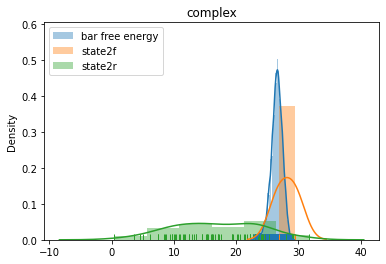

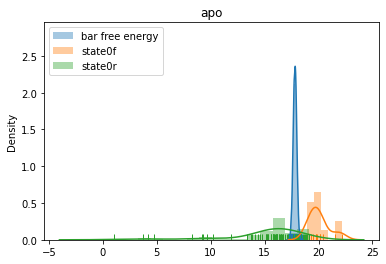

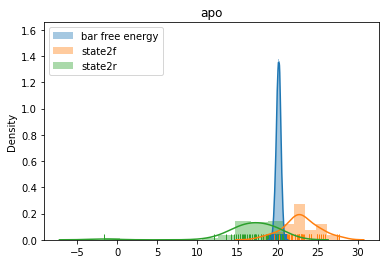

In [54]:
# Plot dgs for each state in apo
for phase in phases:
    states = states_apo if phase == 'apo' else states_complex
    for state in states:
        dgs = [d[phase][state][0] for d in dgs_state_all]
        sns.distplot(dgs, label=f"bar free energy", rug=True)
        sns.distplot(d_input_works[phase]['forward'][state], label=f"state{state}f", rug=True)
        sns.distplot(np.array(d_input_works[phase]['reverse'][state])*-1, label=f"state{state}r", rug=True)
        plt.title(phase)
        plt.legend()
        plt.show()

### Compare states A39D vs D39A

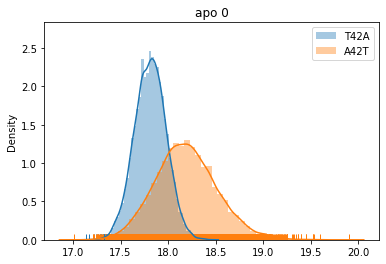

In [55]:
states = [0]
phases = ['apo']
for phase in phases:
    for state in states:
        dgs_T42A = [d[phase][state][0] for d in dgs_state_all_T42A]
        dgs_A42T = [d[phase][state][0] for d in dgs_state_all_A42T]
        sns.distplot(dgs_T42A, label=f"T42A", rug=True)
        sns.distplot(np.array(dgs_A42T)*-1, label=f"A42T", rug=True)
        plt.title(f"{phase} {state}")
        plt.legend()
        plt.show()

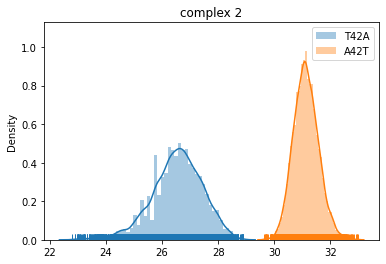

In [57]:
states = [2]
phases = ['complex']
for phase in phases:
    for state in states:
        dgs_T42A = [d[phase][state][0] for d in dgs_state_all_T42A]
        dgs_A42T = [d[phase][state][0] for d in dgs_state_all_A42T]
        sns.distplot(dgs_T42A, label=f"T42A", rug=True)
        sns.distplot(np.array(dgs_A42T)*-1, label=f"A42T", rug=True)
        plt.title(f"{phase} {state}")
        plt.legend()
        plt.show()

## Extract traj

### K27A complex forward traj

In [1]:
import mdtraj as md
import pickle
import os
import numpy as np
from simtk import unit

In [2]:
# Get positions from eq positions of each cycle (positions are solute only)

outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/56/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir)) 
with open(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.npy"), "rb") as f:
    pos_forward_old = np.load(f)
    

In [3]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [4]:
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])

In [5]:
htf._topology_proposal.old_topology.setPeriodicBoxVectors(box_vectors)

In [6]:
htf._topology_proposal.old_topology.getPeriodicBoxVectors()

Quantity(value=array([[6.7997, 0.    , 0.    ],
       [0.    , 6.7997, 0.    ],
       [0.    , 0.    , 6.7997]]), unit=nanometer)

In [7]:
# Write PDB file using openmm bc it will include box vectors
from simtk.openmm import app
app.PDBFile.writeFile(htf._topology_proposal.old_topology, pos_forward_old[0], open(os.path.join(outdir, "test.pdb"), 'w'))

In [8]:
# Load pdb into mdtraj
pdb = md.load(os.path.join(outdir, "test.pdb"))

In [9]:
pdb.unitcell_vectors

array([[[6.7997, 0.    , 0.    ],
        [0.    , 6.7997, 0.    ],
        [0.    , 0.    , 6.7997]]], dtype=float32)

In [10]:
traj = md.Trajectory(pos_forward_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))

In [11]:
traj

<mdtraj.Trajectory with 100 frames, 29474 atoms, 8989 residues, without unitcells at 0x2b49abedcf50>

In [12]:
# Set unit cell vectors in traj based on pdb vectors
traj.unitcell_vectors = np.repeat(pdb.unitcell_vectors, 100, axis=0)

In [13]:
traj.image_molecules()

<mdtraj.Trajectory with 100 frames, 29474 atoms, 8989 residues, and unitcells at 0x2b49493313d0>

In [14]:
traj.save(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.pdb"))

### A39D complex forward traj with work close to 140

In [39]:
import mdtraj as md
import pickle
import os
import numpy as np
from simtk import unit

In [40]:
# Get positions from eq positions of each cycle (positions are solute only)

outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/73/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir)) 
with open(os.path.join(outdir, f"{i}_{phase}_80_forward_neq_new.npy"), "rb") as f:
    pos_forward_new = np.load(f)
    

In [41]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [42]:
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])

In [43]:
htf._topology_proposal.old_topology.setPeriodicBoxVectors(box_vectors)

In [44]:
htf._topology_proposal.old_topology.getPeriodicBoxVectors()

Quantity(value=array([[6.7997, 0.    , 0.    ],
       [0.    , 6.7997, 0.    ],
       [0.    , 0.    , 6.7997]]), unit=nanometer)

In [45]:
# Write PDB file using openmm bc it will include box vectors
from simtk.openmm import app
app.PDBFile.writeFile(htf._topology_proposal.new_topology, pos_forward_new[0], open(os.path.join(outdir, "test.pdb"), 'w'))

In [46]:
# Load pdb into mdtraj
pdb = md.load(os.path.join(outdir, "test.pdb"))

In [47]:
pdb.unitcell_vectors

array([[[6.7997, 0.    , 0.    ],
        [0.    , 6.7997, 0.    ],
        [0.    , 0.    , 6.7997]]], dtype=float32)

In [48]:
traj = md.Trajectory(pos_forward_new, md.Topology.from_openmm(htf._topology_proposal.new_topology))

In [49]:
traj

<mdtraj.Trajectory with 100 frames, 29476 atoms, 8989 residues, without unitcells at 0x2b6652b8b8d0>

In [50]:
# Set unit cell vectors in traj based on pdb vectors
traj.unitcell_vectors = np.repeat(pdb.unitcell_vectors, 100, axis=0)

In [51]:
traj.image_molecules()

<mdtraj.Trajectory with 100 frames, 29476 atoms, 8989 residues, and unitcells at 0x2b65fc8ed150>

In [52]:
traj.save(os.path.join(outdir, f"{i}_{phase}_80_forward_neq_new.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_80_forward_neq_new.pdb"))

# Grab indices of trajs in D39A complex reverse with works close to -160

In [2]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [3]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [4]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
# titles = ["D39A"]
d_results = {}
d_phases = {}
first = 72
for i in tqdm_notebook([72]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


dir: 72
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 25

In [5]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    

In [11]:
for i, work in enumerate(reverse_complex_accumulated):
    if abs(work) < 165 and abs(work) > 155:
        print(i, work)

48 -157.6725672722674
62 -159.49688095337464
72 -155.455073281715


# Grab indices of trajs in A39D complex forward with works far from -160

In [31]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:matplotlib:(private) matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases'

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [32]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [33]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
# titles = ["D39A"]
d_results = {}
d_phases = {}
first = 73
for i in tqdm_notebook([73]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


dir: 73
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 25

In [34]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    

In [38]:
for i, work in enumerate(forward_complex_accumulated):
    if abs(work) > 130:
        print(i, work)

11 -131.0036411382579
17 -133.59138746807292
33 -135.019367829651
36 -132.9313754151517
39 -134.07096241966784
40 -130.1146226969148
47 -134.48549176583415
48 -133.70815831053218
53 -131.8473938485725
79 -136.03946090010166
80 -136.47387534891928
82 -132.0389176488211
84 -131.93493631181718
91 -133.6036721861534
92 -132.05519750766948
